In [ ]:
!pwd

/content


In [ ]:
!unzip -qq "/content/drive/MyDrive/dev_ws/DeepLearning/archive.zip"

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path = '/content/Face Mask Dataset/'
dataset = {
    "image_path": [],
    "mask_status": [],
    "where": []
}

for where in os.listdir(path):
  for status in os.listdir(path + "/" + where):
    for image in glob.glob(path + where + "/" + status + "/" + "*.png"):
      dataset["image_path"].append(image)
      dataset["mask_status"].append(status)
      dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,/content/Face Mask Dataset/Validation/WithMask...,WithMask,Validation
1,/content/Face Mask Dataset/Validation/WithMask...,WithMask,Validation
2,/content/Face Mask Dataset/Validation/WithMask...,WithMask,Validation
3,/content/Face Mask Dataset/Validation/WithMask...,WithMask,Validation
4,/content/Face Mask Dataset/Validation/WithMask...,WithMask,Validation


With Mask: 5909
Without Mask: 5883


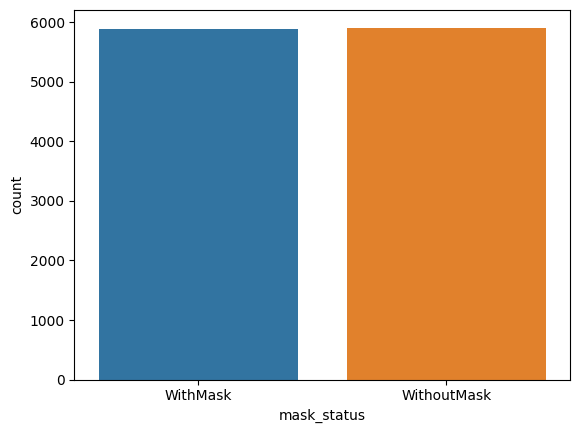

In [ ]:
print(f"With Mask:", dataset.value_counts("mask_status")[0])
print(f"Without Mask:", dataset.value_counts("mask_status")[1])

sns.countplot(x = dataset["mask_status"]);

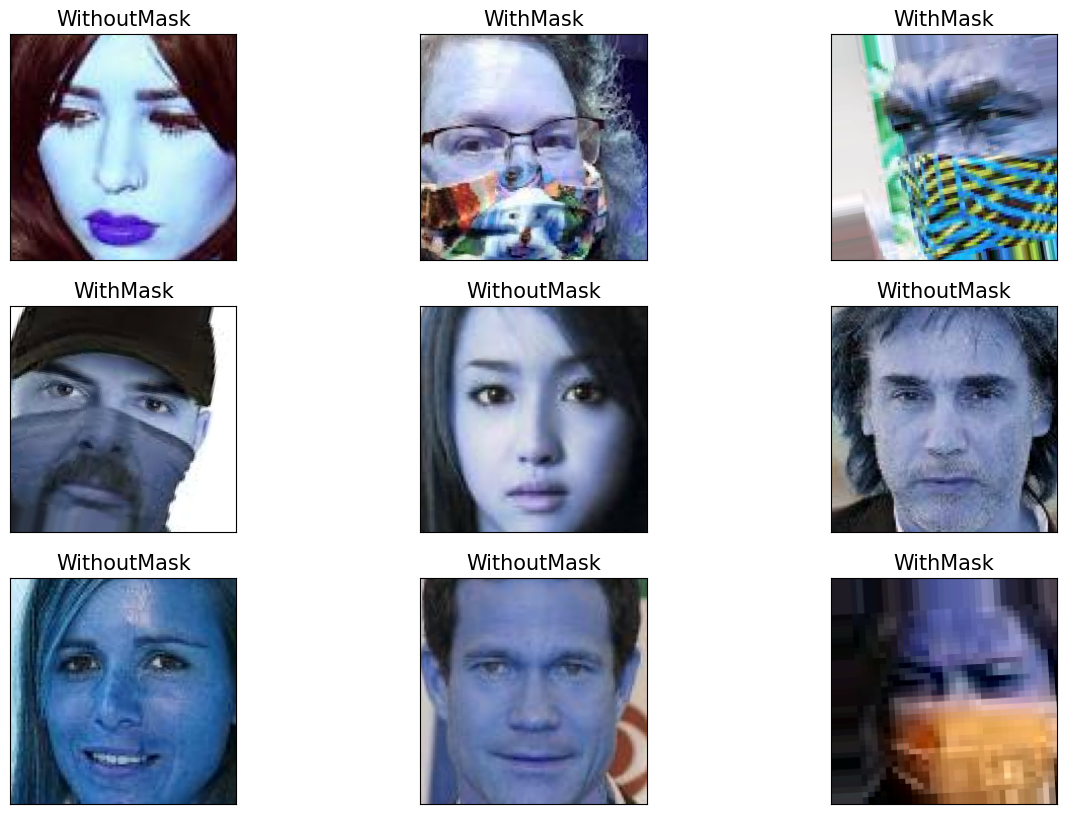

In [ ]:
import cv2

plt.figure(figsize = (15, 10))
for i in range(9):
  random = np.random.randint(1, len(dataset))
  plt.subplot(3, 3, i+1)
  plt.imshow(cv2.imread(dataset.loc[random, "image_path"]))
  plt.title(dataset.loc[random, "mask_status"], size = 15)
  plt.xticks([])
  plt.yticks([])
plt.show()

In [ ]:
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

print(train_df.head(10))

                                            image_path mask_status  where
800  /content/Face Mask Dataset/Train/WithMask/Augm...    WithMask  Train
801  /content/Face Mask Dataset/Train/WithMask/Augm...    WithMask  Train
802  /content/Face Mask Dataset/Train/WithMask/Augm...    WithMask  Train
803  /content/Face Mask Dataset/Train/WithMask/823.png    WithMask  Train
804  /content/Face Mask Dataset/Train/WithMask/Augm...    WithMask  Train
805  /content/Face Mask Dataset/Train/WithMask/759.png    WithMask  Train
806  /content/Face Mask Dataset/Train/WithMask/Augm...    WithMask  Train
807  /content/Face Mask Dataset/Train/WithMask/Augm...    WithMask  Train
808  /content/Face Mask Dataset/Train/WithMask/Augm...    WithMask  Train
809  /content/Face Mask Dataset/Train/WithMask/229.png    WithMask  Train


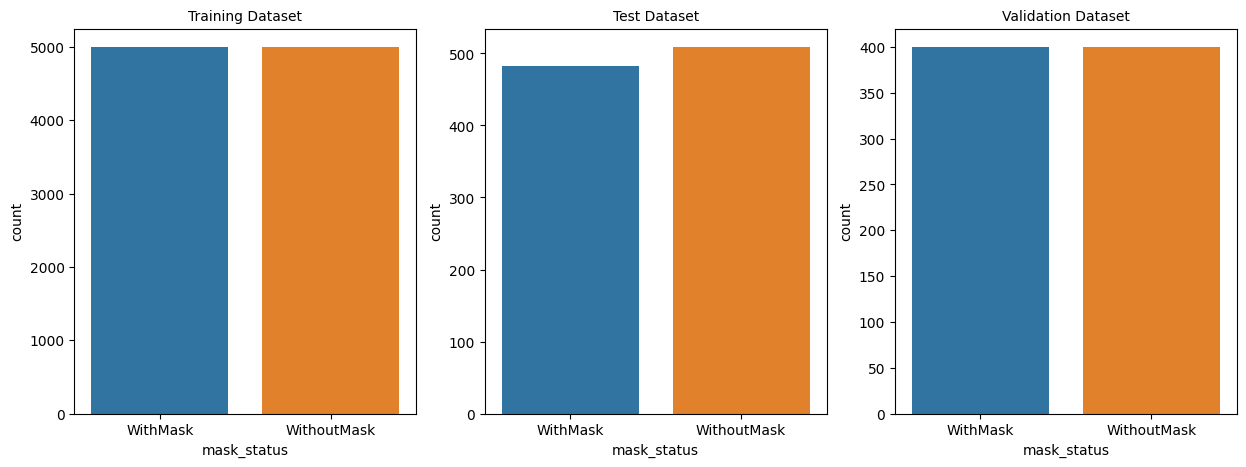

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df["mask_status"])
plt.title("Training Dataset", size = 10)

plt.subplot(1, 3, 2)
sns.countplot(x = test_df["mask_status"])
plt.title("Test Dataset", size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = valid_df["mask_status"])
plt.title("Validation Dataset", size = 10)

plt.show()

In [ ]:
train_df = train_df.reset_index().drop("index", axis = 1)
train_df.head()

,image_path,mask_status,where
0,/content/Face Mask Dataset/Train/WithMask/Augm...,WithMask,Train
1,/content/Face Mask Dataset/Train/WithMask/Augm...,WithMask,Train
2,/content/Face Mask Dataset/Train/WithMask/Augm...,WithMask,Train
3,/content/Face Mask Dataset/Train/WithMask/823.png,WithMask,Train
4,/content/Face Mask Dataset/Train/WithMask/Augm...,WithMask,Train


In [ ]:
data = []
image_size = 150

for i in range(len(train_df)):
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    if train_df["mask_status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [ ]:
type(data)

list

In [ ]:
data = np.array(data)
type(data)

<ipython-input-23-2657eb8d4193>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data)


numpy.ndarray

In [ ]:
np.random.shuffle(data)

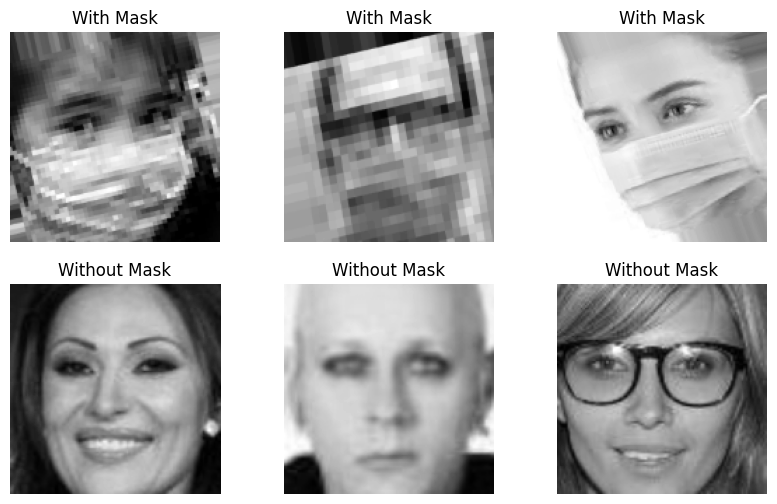

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (10, 6))
for row in range(2):
    for col in range(3):
        image_index = row * 100 + col
        ax[row, col].axis("off")
        ax[row, col].imshow(data[image_index][0], cmap = "gray")
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")
plt.show()

In [ ]:
data[0]

array([array([[ 33,  33,  37, ..., 118, 118, 118],
              [ 33,  33,  35, ..., 120, 123, 126],
              [ 33,  33,  33, ..., 131, 131, 131],
              ...,
              [ 96,  94,  91, ...,   6,   6,   8],
              [ 85,  83,  83, ...,   6,   6,   8],
              [ 83,  83,  83, ...,   6,   6,   7]], dtype=uint8), 1],
      dtype=object)

In [ ]:
x = []
y = []
for image in data:
    x.append(image[0])
    y.append(image[1])
x = np.array(x)
y = np.array(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 13)

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, kernel_size = (5, 5), strides = (1, 1),
                  padding = 'same', activation = 'relu',
                  input_shape = (150, 150, 1)),
    layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    layers.Conv2D(64, (2,2), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        8256      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 37, 37, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 87616)            

In [ ]:
model.compile(optimizer = 'adam',
               loss = tf.keras.losses.BinaryCrossentropy(),
               metrics = ['accuracy'])

In [ ]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)
history = model.fit(X_train, y_train, epochs = 5, batch_size = 32)

Epoch 1/5
250/250 [==============================] - 24s 44ms/step - loss: 33.6227 - accuracy: 0.8846
Epoch 2/5
250/250 [==============================] - 13s 51ms/step - loss: 0.0671 - accuracy: 0.9758
Epoch 3/5
250/250 [==============================] - 13s 50ms/step - loss: 0.0532 - accuracy: 0.9810
Epoch 4/5
250/250 [==============================] - 12s 49ms/step - loss: 0.0173 - accuracy: 0.9939
Epoch 5/5
250/250 [==============================] - 13s 51ms/step - loss: 0.0127 - accuracy: 0.9954


In [ ]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 1s 10ms/step - loss: 0.1203 - accuracy: 0.9740


[0.12030068039894104, 0.9739999771118164]

In [ ]:
prediction = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

63/63 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       959
           1       0.96      0.99      0.98      1041

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

[[ 919   40]
 [  12 1029]]


In [ ]:
model2 = models.Sequential([
    layers.Conv2D(32, kernel_size = (5, 5), strides = (1, 1),
                  padding = 'same', activation = 'relu',
                  input_shape = (150, 150, 1)),
    layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    layers.Conv2D(64, (2,2), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      832       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 64)        8256      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 37, 37, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 87616)            

In [ ]:
model2.compile(optimizer = 'adam',
               loss = tf.keras.losses.BinaryCrossentropy(),
               metrics = ['accuracy'])

In [ ]:
X = []
y = []
for image in data:
    X.append(image[0])
    y.append(image[1])

X = np.array(x)
y = np.array(y)
X = X/255
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 13)

X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)

history = model2.fit(X_train, y_train, epochs = 5, batch_size = 32)

Epoch 1/5
250/250 [==============================] - 14s 49ms/step - loss: 0.2838 - accuracy: 0.9013
Epoch 2/5
250/250 [==============================] - 12s 48ms/step - loss: 0.0644 - accuracy: 0.9774
Epoch 3/5
250/250 [==============================] - 12s 47ms/step - loss: 0.0472 - accuracy: 0.9830
Epoch 4/5
250/250 [==============================] - 13s 52ms/step - loss: 0.0278 - accuracy: 0.9905
Epoch 5/5
250/250 [==============================] - 13s 52ms/step - loss: 0.0220 - accuracy: 0.9920


In [ ]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 1s 10ms/step - loss: 2.8339 - accuracy: 0.5205


[2.833944797515869, 0.5205000042915344]

In [ ]:
prediction = (model2.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

63/63 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       959
           1       0.98      0.98      0.98      1041

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

[[ 937   22]
 [  26 1015]]


In [ ]:
wrong_result = []
for n in range(0, len(y_val)):
    if prediction[n] != y_val[n]:
        wrong_result.append(n)
len(wrong_result)

48

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


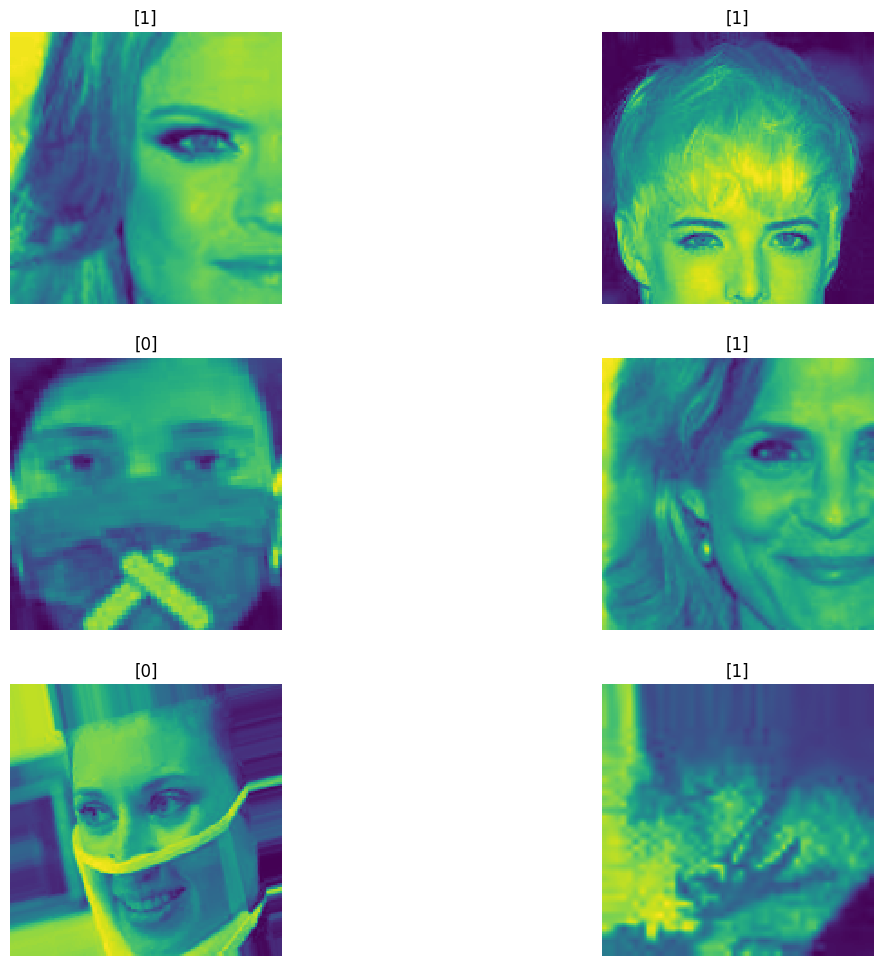

In [ ]:
import random
samples = random.choices(population = wrong_result, k = 6)
plt.figure(figsize = (14, 12))
for idx, n in enumerate(samples):
    plt.subplot(3, 2, idx + 1)
    plt.imshow(X_val[n].reshape(150, 150), interpolation = 'nearest')
    plt.title(prediction[n])
    plt.axis('off')
plt.show()